In [5]:
import pandas as pd
import numpy as np

In [6]:
co = pd.read_csv('co_agco_new.csv', sep = '|', low_memory=False)

In [7]:
cd = pd.read_csv('cd_agco_new.csv', sep = '|', low_memory=False)

In [8]:
cod = pd.merge(co, cd, on='co_id', how='inner')

In [7]:
#codlocations = cod['supply_location_id'].unique()

In [9]:
locations = pd.read_csv('locations_agco_new.csv', sep='|', low_memory=False)

In [10]:
cod_loc = pd.merge(cod, locations, left_on='supply_location_id', right_on='location_id', how='left')

In [21]:
#cod_loc_no_dealer = cod_loc[pd.isnull(cod_loc['group1'])]
#locations_no_dealer = cod_loc_no_dealer['supply_location_id'].unique()
#dealer = cod_loc['group1'].unique()
#dealer_from_loc = locations['group1'].unique()

In [11]:
dealer_items = cod_loc[['group1', 'item_id', 'requested_quantity']]

In [12]:
user_item = dealer_items.groupby(by=['group1', 'item_id']).sum().reset_index()

In [13]:
user_item.columns = ['user', 'item', 'purchases']

In [14]:
user_item = user_item.loc[user_item.purchases > 0]
user_item['purchases'] = np.clip(user_item.purchases, a_min=1, a_max=np.percentile(user_item.purchases, 90))
user_item['user'] = pd.Categorical(user_item.user).codes
user_item['item'] = pd.Categorical(user_item.item).codes
user_item.head()

,user,item,purchases
0,0,46,1.0
1,0,47,1.0
2,0,120,4.0
3,0,956,4.0
4,0,1373,1.0


In [15]:
from scipy.sparse import coo_matrix, csr_matrix
user_item_coo = coo_matrix((user_item.purchases, (user_item.user, user_item.item)))
user_item_coo

<284x283284 sparse matrix of type '<class 'numpy.float64'>'
	with 2139370 stored elements in COOrdinate format>

In [16]:
user_item_csr = user_item_coo.tocsr()
user_item_csr.shape

(284, 283284)

In [17]:
def avg_items(csr):
    df = pd.DataFrame({'user' : csr.tocoo().row, 'item' : csr.tocoo().col})
    df_agg = df.groupby(by=['user']).count()
    return df_agg.item

In [18]:
num_items_agco_co = avg_items(user_item_csr.T)

<AxesSubplot:>

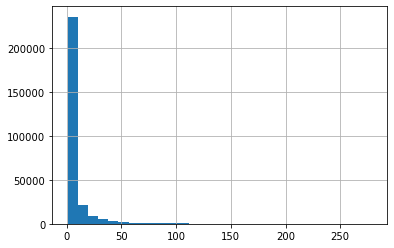

In [19]:
num_items_agco_co.hist(bins=30)

<AxesSubplot:>

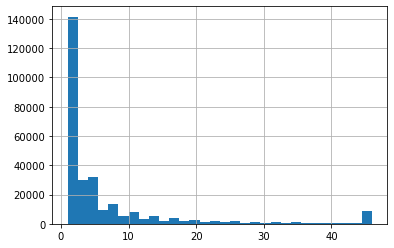

In [20]:
np.clip(num_items_agco_co, a_min=1, a_max=np.percentile(num_items_agco_co, 97)).hist(bins=30)

In [21]:
num_items_agco_co.describe()

count    283284.000000
mean          7.552033
std          15.085776
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         279.000000
Name: item, dtype: float64

In [28]:
(num_items_agco_co < 1000).sum()

18

<AxesSubplot:>

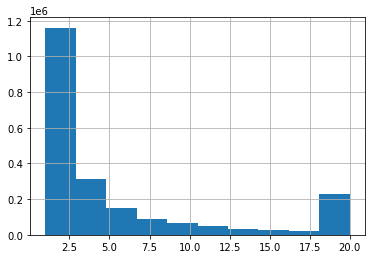

In [16]:
pd.Series(user_item_csr.data).hist()

In [42]:
user_item_csr.nnz / (user_item_csr.shape[0] * user_item_csr.shape[1])

0.026591664046492137

In [43]:
1 - (user_item_csr.nnz / (user_item_csr.shape[0] * user_item_csr.shape[1]))

0.9734083359535078

In [22]:
from implicit.evaluation import train_test_split, ranking_metrics_at_k
from implicit.als import AlternatingLeastSquares

In [23]:
train, test = train_test_split(user_item_csr)

In [25]:
model = AlternatingLeastSquares(factors=128, regularization=0.1, use_native=True, use_cg=True)

In [26]:
model.fit(train * 20)

100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


In [41]:
eval_df = evaluate_model(model, train, test, 10, user_item_csr)
eval_df

100%|██████████| 284/284 [00:00<00:00, 807.95it/s]


,precision,map,ndcg,auc,mpr
10,0.432394,0.27782,0.424649,0.502836,0.162673


In [27]:
metrics = ranking_metrics_at_k(model, train, test, K=10)
metrics

100%|██████████| 284/284 [00:00<00:00, 579.40it/s]


{'precision': 0.4323943661971831,
 'map': 0.2778195562262465,
 'ndcg': 0.4246489647768013,
 'auc': 0.5028360577351756}

In [33]:
mpr = calc_mpr(model, train, test, user_item_csr)

In [39]:
pd.DataFrame(metrics, index=['5'])

,precision,map,ndcg,auc,mpr
5,0.432394,0.27782,0.424649,0.502836,0.162673


In [42]:
# MPR per user and mpr complete function
def mpr_per_user(model, train, test, num_recs, user):
    recommended_items = model.recommend(user_items=train[user], userid=user, filter_already_liked_items=True, N = num_recs)[0]
    test_items = test[user].nonzero()[1]
    test_items_in_list = test_items[np.isin(test_items, recommended_items)]
    if len(test_items_in_list) == 0:
        return 0.5
    recommended_indices = recommended_items.argsort()
    hit_indices = recommended_indices[np.searchsorted(recommended_items[recommended_indices], test_items_in_list)]
    #return (np.sum(hit_indices) / num_recs) / len(hit_indices)
    return np.mean(hit_indices / num_recs)

# complete function over all users
def calc_mpr(model, train, test, full_csr):
    mprs = []
    for u in range(full_csr.shape[0]) :
        mpr = mpr_per_user(model, train, test, full_csr.shape[1], u)
        mprs.append(mpr)
    return {'mpr' : np.mean(mprs)} 

# integrated evaluation function with all metrics, can be extended
def evaluate_model(model, train, test, k, user_item_csr):
    metrics = ranking_metrics_at_k(model, train, test, K=k)
    mpr = calc_mpr(model, train, test, user_item_csr)
    metrics.update(mpr)
    return pd.DataFrame(metrics, index=[str(k)])  
    

In [33]:
test_filter = dealer_items[(dealer_items['item_id'] == '001051620') & (dealer_items['group1'] == 'ACA')]

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [2]:
import findspark
findspark.init()

In [3]:
spark = SparkSession.builder.getOrCreate()

RuntimeError: Java gateway process exited before sending its port number

In [16]:
ratings = spark.createDataFrame(user_item)

NameError: name 'spark' is not defined